In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve_triangular

import tornadox
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import pof
from pof.main import (
    make_continuous_models,
    discretize_transitions,
    get_constant_initial_trajectory,
    linearize_observation_model,
    get_x0,
)
from pof.ieks import filtsmooth, smoothing
from pof.solve import solve_diffrax
from pof.utils import tria

In [3]:
order = 3
dt = 1e-4

First define the IVP and compute a reference solution with diffrax

(-3.0, 3.0)

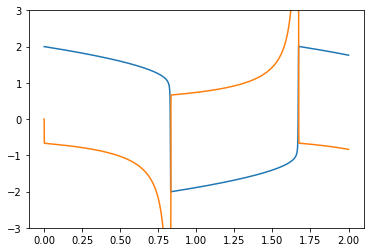

In [4]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e3, tmax=2)
ylims = (-3, 3)

#ts_true, ys_true, sol_true = solve_diffrax(ivp, rtol=1e-10, atol=1e-10)
ts_true, ys_true, sol_true = solve_diffrax(ivp, dt=dt)
plt.plot(ts_true, ys_true)
plt.ylim(*ylims)

We now want to solve it with a time-parallel IEKS.

# Solving IVPs with the IEKS
We already did this in previous notebooks, but now the structure is a bit different: first create a continuous model, then discretize it, and then run a linear filter/smoother on that.

In [5]:
# define the time grid
ts = jnp.arange(0, ivp.tmax + dt, dt)
# make a constant initial trajectory from y0
traj = get_constant_initial_trajectory(ivp.y0, order, len(ts))

# make the continuous transition and observation models
iwp, om = make_continuous_models(ivp, order)
E0 = pof.transitions.projection_matrix(iwp, 0)

# make the discrete transition and observation model
dtm = discretize_transitions(iwp, ts)
lom = jax.jit(linearize_observation_model, static_argnums=0)
dom = lom(om, traj[1:])

# for the initial guess, use Taylor-mode autodiff as usual via tornadox
x0 = get_x0(ivp, order)

In [6]:
%%time
fs = jax.jit(filtsmooth)

CPU times: user 162 µs, sys: 0 ns, total: 162 µs
Wall time: 170 µs


CPU times: user 23min 13s, sys: 15.6 s, total: 23min 29s
Wall time: 21min 30s


(-3.0, 3.0)

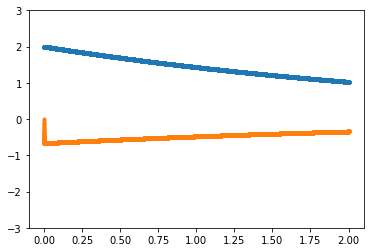

In [7]:
%%time
out = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts, ys, marker=".")
plt.ylim(*ylims)

Make GIF

In [ ]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

dom = lom(om, traj[1:])
out = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
plt.plot(ts_true, ys_true, "--", color="black")
plt.plot(ts, ys, color="C0")
plt.ylim(*ylims)
plt.text(0, ylims[1]-0.5, f"Iteration 0")
camera.snap()

for i in trange(1, 2_000):
    dom = lom(om, out.mean[1:])
    out = fs(x0, dtm, dom)
    ys = jnp.dot(E0, out.mean.T).T
    plt.plot(ts_true, ys_true, "--", color="black")
    plt.plot(ts, ys, color="C0")
    plt.ylim(*ylims)
    plt.text(0, ylims[1]-0.5, f"Iteration {i}")
    camera.snap()

animation = camera.animate()

  0%|          | 0/1999 [00:00<?, ?it/s]

In [ ]:
animation.save('animation.gif')